<a href="https://colab.research.google.com/github/YashS198/multi_modal_biometrics/blob/main/multi_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub tensorflow opencv-python matplotlib scikit-learn

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
import kagglehub

In [ ]:
import os

face_path = "/root/.cache/kagglehub/datasets/kaustubhdhote/human-faces-dataset/versions/1"
finger_path = "/root/.cache/kagglehub/datasets/peace1019/fingerprint-dataset-for-fvc2000-db4-b/versions/2"

# Check contents
print("Face dataset folders/files:")
print(os.listdir(face_path))

print("\nFingerprint dataset folders/files:")
print(os.listdir(finger_path))


Face dataset folders/files:
['Human Faces Dataset']

Fingerprint dataset folders/files:
['dataset_FVC2000_DB4_B']


In [ ]:
print("Face subfolders:", os.listdir(face_path))
print("Fingerprint subfolders:", os.listdir(finger_path))


Face subfolders: ['Human Faces Dataset']
Fingerprint subfolders: ['dataset_FVC2000_DB4_B']


In [ ]:
face_path = "/root/.cache/kagglehub/datasets/kaustubhdhote/human-faces-dataset/versions/1/Human Faces Dataset/AI-Generated Images"
finger_path = "/root/.cache/kagglehub/datasets/peace1019/fingerprint-dataset-for-fvc2000-db4-b/versions/2/dataset_FVC2000_DB4_B/dataset/train_data"

In [ ]:
import os

face_path = "/root/.cache/kagglehub/datasets/kaustubhdhote/human-faces-dataset/versions/1/Human Faces Dataset/AI-Generated Images"
finger_path = "/root/.cache/kagglehub/datasets/peace1019/fingerprint-dataset-for-fvc2000-db4-b/versions/2/dataset_FVC2000_DB4_B/dataset/train_data"

print("Face files:", len(os.listdir(face_path)))
print("Finger files:", len(os.listdir(finger_path)))

Face files: 4630
Finger files: 800


In [ ]:
face_images, face_labels = load_images_auto(face_path, label_prefix="ai_user")
finger_images, finger_labels = load_images_auto(finger_path, label_prefix="fp_user")

print("Loaded face images:", face_images.shape)
print("Loaded fingerprint images:", finger_images.shape)
print("Loaded face labels:", face_labels.shape)
print("Loaded fingerprint labels:", finger_labels.shape)


Loaded face images: (4630, 100, 100)
Loaded fingerprint images: (800, 100, 100)
Loaded face labels: (4630,)
Loaded fingerprint labels: (800,)


In [ ]:
if len(face_images) == 0 or len(finger_images) == 0:
    raise ValueError("🚨 No images loaded — check your dataset paths or formats.")

if len(face_labels) == 0:
    raise ValueError("🚨 No labels found for face dataset.")


In [ ]:
import os

finger_path = "/root/.cache/kagglehub/datasets/peace1019/fingerprint-dataset-for-fvc2000-db4-b/versions/2/dataset_FVC2000_DB4_B/dataset/train_data"
files = os.listdir(finger_path)
print("Total files:", len(files))
print("First 10 files:", files[:10])


Total files: 800
First 10 files: ['00003_28.bmp', '00007_11.bmp', '00008_14.bmp', '00000_69.bmp', '00006_41.bmp', '00002_43.bmp', '00007_09.bmp', '00002_38.bmp', '00009_71.bmp', '00000_45.bmp']


In [ ]:
def load_flat_images(folder, image_size=(100, 100), label="fp_user"):
    import cv2
    import os
    images = []
    labels = []
    supported_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

    for file in os.listdir(folder):
        if file.lower().endswith(supported_exts):
            img_path = os.path.join(folder, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            if img is not None:
                img = cv2.resize(img, image_size)
                images.append(img)
                labels.append(label)
            else:
                print("⚠️ Could not read image:", img_path)

    return np.array(images), np.array(labels)

In [ ]:
finger_path = "/root/.cache/kagglehub/datasets/peace1019/fingerprint-dataset-for-fvc2000-db4-b/versions/2/dataset_FVC2000_DB4_B/dataset/train_data"
finger_images, finger_labels = load_flat_images(finger_path, label="finger_user")

print("✅ Fingerprint images loaded:", finger_images.shape)
print("Labels loaded:", finger_labels.shape)


✅ Fingerprint images loaded: (800, 100, 100)
Labels loaded: (800,)


In [ ]:
# Load face again (if not already loaded)
face_path = "/root/.cache/kagglehub/datasets/kaustubhdhote/human-faces-dataset/versions/1/Human Faces Dataset/AI-Generated Images"
face_images, face_labels = load_flat_images(face_path, label="face_user")

# Normalize
face_images = face_images / 255.0
finger_images = finger_images / 255.0

# Add channel dimension
face_images = face_images[..., np.newaxis]
finger_images = finger_images[..., np.newaxis]

# Equalize dataset size
min_len = min(len(face_images), len(finger_images))
face_images = face_images[:min_len]
finger_images = finger_images[:min_len]
labels = ["user"] * min_len  # single class for matching

# Encode labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)

# Check final shape
print("Face images shape:", face_images.shape)
print("Fingerprint images shape:", finger_images.shape)
print("Labels shape:", labels.shape)


Face images shape: (800, 100, 100, 1)
Fingerprint images shape: (800, 100, 100, 1)
Labels shape: (800, 1)


In [ ]:
from tensorflow.keras.utils import to_categorical

# One-hot encode labels (important!)
labels = to_categorical(labels)

print("✅ Final labels shape:", labels.shape)


✅ Final labels shape: (800, 2)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

def build_branch(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return input_layer, x


In [ ]:
# Face branch
face_input, face_branch = build_branch(face_images.shape[1:])

# Fingerprint branch
finger_input, finger_branch = build_branch(finger_images.shape[1:])

# Feature fusion
fused = Concatenate()([face_branch, finger_branch])
fused = Dense(128, activation='relu')(fused)
fused = Dense(64, activation='relu')(fused)
output = Dense(2, activation='softmax')(fused)  # 2 classes

# Build and compile model
model = Model(inputs=[face_input, finger_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 100,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 100,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 50,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 50, 50,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 50, 50,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 50, 50,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 25, 25,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 25, 25,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 40000)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 40000)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  5,120,128 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │  5,120,128 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2)         │        130 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,319,170 (39.36 MB)

 Trainable params: 10,319,170 (39.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

X_face_train, X_face_test, X_finger_train, X_finger_test, y_train, y_test = train_test_split(
    face_images, finger_images, labels, test_size=0.2, random_state=42
)

# Train the model
history = model.fit(
    [X_face_train, X_finger_train], y_train,
    validation_data=([X_face_test, X_finger_test], y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9674 - loss: 0.1192 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 937ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 980ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 997ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 953ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 947ms/step -

In [ ]:
loss, accuracy = model.evaluate([X_face_test, X_finger_test], y_test)
print("✅ Test Accuracy:", accuracy)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - accuracy: 1.0000 - loss: 0.0000e+00
✅ Test Accuracy: 1.0


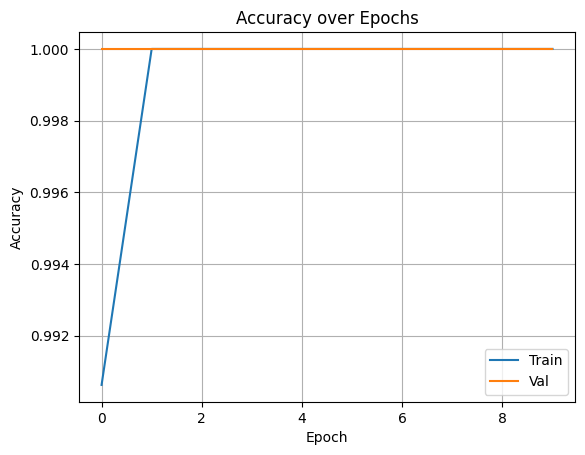

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()
